# Logistic Regression vs. Bayesian Classifier

## Running required packages

In [4]:
# Data Generation
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

## Loading required data

In [5]:
# creating train and test data from csv file
train = read.csv("Task2D_train.csv",header=TRUE)
test = read.csv("Task2D_test.csv",header=TRUE)

# shuffling the train and test
train <- train[sample(nrow(train)),]
test <- test[sample(nrow(test)),]

# creating train labels and test labels
train.data <- train[,-ncol(train)]
train.label <- as.vector(train[,ncol(train)])
test.data <- test[,-ncol(test)]
test.label <- as.vector(test[,ncol(test)])

## Bayes Classifier

In [6]:
bayesclassifier <- function(train.data,train.label,test.data,test.label){
    # Class probabilities:
    p0.hat <- sum(train.label==1)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==-1)/nrow(train.data) # or simply 1 - p1.hat
    
    # Class means:
    mu0.hat <- colMeans(train.data[train.label==1,])
    mu1.hat <- colMeans(train.data[train.label==-1,])
    
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==1,])
    sigma1.hat <- var(train.data[train.label==-1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, 1, -1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), 1, -1)
    test_error = sum(test.predict != test.label)/nrow(test.data)
    return(test_error)
}

## Logistic regression

### Auxillary function

In [16]:
# auxiliary function that predicts class labels
predict <- function(w, X){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, 1,0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

### Initialization

In [17]:
logisticreg <- function(train.data,train.label){
    # Initializations
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==-1,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)
    

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T)

    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T)<=epsilon


        # for each datapoint:
        for (i in 1:nrow(train.data)){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    return(W[tau,])
}

In [20]:
# iterator for test error
i = 1

#initializing test_error matrix
test_error = matrix(,nrow=nrow(train.data)/5,ncol=3)
colnames(test_error) <- c('Bayes error','logistic.error','i')

# for each datapoint
for (k in 1:nrow(train.data)){
    # for every 5 datapoints
    if (k%%5 == 0){
        # new train data
        t_data = train.data[1:k,]
        t_label = train.label[1:k]
        
        # test error from bayes classifier
        test_error[i,1] <- bayesclassifier(t_data,t_label,test.data,test.label)
        # weight vector from logistic model
        W <- logisticreg(t_data,t_label)
        # test error for logistic model
        pred_test <- predict(W,test.data)
        T <- ifelse(test.label==-1,0,1)
        test_error[i,2] <- sum(pred_test!=T)/nrow(test.data)
        test_error[i,3] <- i
        i = i + 1
    }
}

## Plotting test errors from bayes classifier and logistic regression

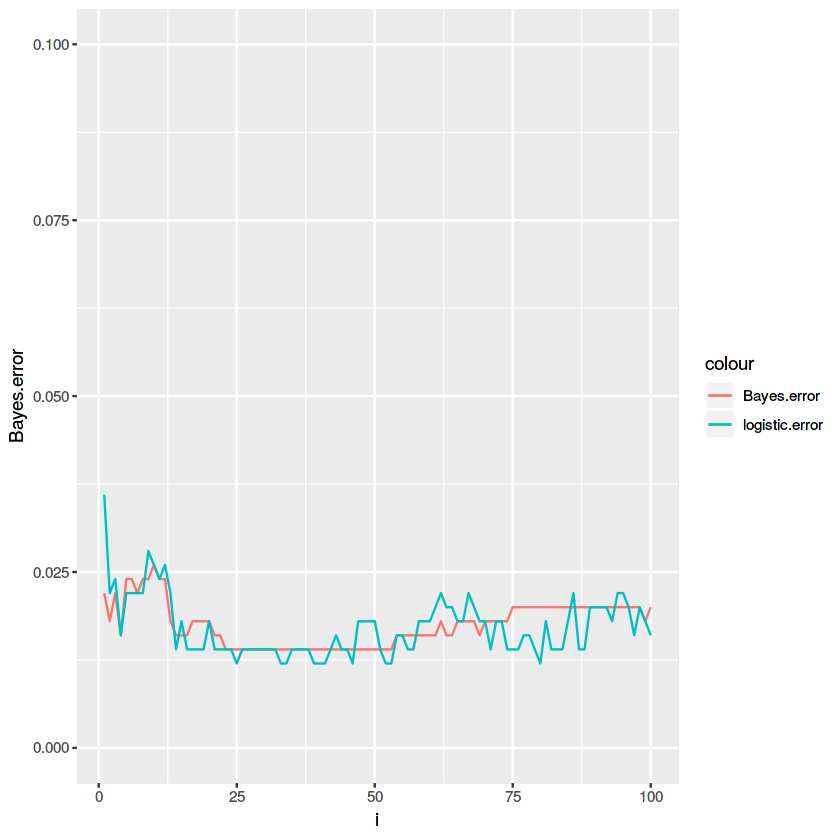

In [25]:
# convert to dataframe
test_error = data.frame(test_error)

# plotting error using ggplots
y <- ggplot(test_error,aes(x=i,y=Bayes.error))+geom_line(aes(color='Bayes.error'))
z <- y +geom_line(aes(x=i,y=logistic.error,color='logistic.error'))+coord_cartesian(ylim = c(0, 0.1))

plot(z)

**What does happen for each classifier when the number of training
data points is increased?**

As the number of training data points increases, bias of the model decrease and variance increase. At the begining test error, test error of both classifiers is higher and same at the end.

**Which classifier is best suited when the training set is small, and
which is best suited when the training set is big?**

Bayes classifiers assumes features are independent from each other But real data is dependent. Bayes always tries to figure how data is generated while logistic regression take probability has a confidence level to classify. for small training data, Bayes classifier is preferred over logistic regression and vice verse.

**Justify your observations in previous questions (III.a & III.b) by
providing some speculations and possible reasons.**

Bias of both calssifiers is decreasing whereas variance increasing. hence, from the fundamental concepts test error always will be low at bias and variance tradoff. logistic regression is more complex model cause during the training phase, weights are updated based on the probability of input features while bayes is less complex. So, learning rate of Bayes is greater than logistic when training data is small. If training data is big, logitics regression is favoured since it weights are so stable will not effected variance and same cant be said about Bayes. 